# Train of thought
1. 对https://movie.douban.com/top250 F12获取单个电影样例分析结构，难点在于正则表达提取主演导演那行信息
2. 保存csv，分析行列。
3. 熟悉pandas常用几个方法nlargest\groupby\agg\explode

<div class="item">
    <div class="pic">
        <em class="">1</em>
        <a href="https://movie.douban.com/subject/1292052/">
            <img alt="肖申克的救赎" class="" src="https://img3.doubanio.com/view/photo/s_ratio_poster/public/p480747492.jpg" width="100" />
        </a>
    </div>
    <div class="info">
        <div class="hd">
            <a class="" href="https://movie.douban.com/subject/1292052/">
                <span class="title">肖申克的救赎</span>
                <span class="title"> / The Shawshank Redemption</span>
                <span class="other"> / 月黑高飞(港) / 刺激1995(台)</span>
            </a>
            <span class="playable">[可播放]</span>
        </div>
        <div class="bd">
            <p class="">
                导演: 弗兰克·德拉邦特 Frank Darabont   主演: 蒂姆·罗宾斯 Tim Robbins /...<br />
                1994 / 美国 / 犯罪 剧情
            </p>
            <div class="star">
                <span class="rating5-t"></span>
                <span class="rating_num" property="v:average">9.7</span>
                <span content="10.0" property="v:best"></span>
                <span>3111801人评价</span>
            </div>
            <p class="quote">
                <span class="inq">希望让人自由。</span>
            </p>
        </div>
    </div>
</div>

# Part 1: Web Scraping
## Web Scraping
### Task: Scrap the following information from IMDb Top 250 movies:

#### 1. Name
#### 2. Rating
#### 3. Number of votes
#### 4. Release year
#### 5. Country/Region
#### 6. Genre

In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def get_page_movies(url, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Get movie list
    pages_items = soup.find_all('div', class_='item')
    # Parse data...
    return pages_items

def extract_from_per_movie(per_movie):
    def deal_special_element():
        # 获取电影导演、演员、年份、上映地区等信息
        special_info = per_movie.find('div', class_='bd').find('p').text.strip()
        # 这条数据包含了很多信息，需要使用正则拆分开
        pattern = re.compile(r"(\d{4})\s*(?:\([^)]+\))?\s*/\s*([a-zA-Z\u4e00-\u9fa5]+(?:\s+[a-zA-Z\u4e00-\u9fa5]+)*)\s*/\s*([a-zA-Z\u4e00-\u9fa5\s]+)")
        match = re.search(pattern, special_info)
        special_dict = {}
        if match:
            year = match.group(1).strip()
            countries = match.group(2).strip().split()
            genres = match.group(3).strip().split()
            # special_dict = {'director': director, 'actors': actors, 'release_year': year, 'country': countries, 'genre': genres}
            special_dict = {'year': year, 'country': countries, 'genre': genres}
        return special_dict
    
    def convert2number(votes_str):
        pattern = re.compile(r'\d+')
        match = pattern.search(votes_str)
        return match.group() if match else votes_str
    
    # 获取排名
    rank = per_movie.find('em').text.strip()
    # 获取电影标题
    title = per_movie.find('span', class_='title').text.strip()
    # 获取评分信息
    rating_num = per_movie.find('span', class_='rating_num').text.strip()
    # 获取评价人数信息
    votes_str = per_movie.find('div', class_='star').find_all('span')[3].text.strip()
    need_data = {'rank': rank, 'name': title, 'rating': rating_num, 'votes': convert2number(votes_str)}
    
    special_dict = deal_special_element()
    need_data.update(special_dict)
    return need_data

if __name__ == "__main__":
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36 Edg/131.0.0.0'}
    base_url = 'https://movie.douban.com/top250?start={start}'
    base_number, page_size = 0, 25
    url_list = []
    # 每个电影包含的6个特征，按排名排序
    ranked_movie_list = []
    for index in range(0, 10):
        url_list.append(base_url.format(start=base_number))
        base_number += page_size

    for url in url_list:
        page_movies = get_page_movies(url, headers=headers)
        #每页25个电影，只有第一个抽样打印
        for index in range(len(page_movies)):
            per_need_data = extract_from_per_movie(page_movies[index])
            if index == 0:
                print(per_need_data)
            ranked_movie_list.append(per_need_data)
    # 将数据保存为 CSV 文件
    df = pd.DataFrame(ranked_movie_list)
    df.to_csv('douban.csv', index=False)

{'rank': '1', 'name': '肖申克的救赎', 'rating': '9.7', 'votes': '3113349', 'year': '1994', 'country': ['美国'], 'genre': ['犯罪', '剧情']}
{'rank': '26', 'name': '末代皇帝', 'rating': '9.3', 'votes': '968924', 'year': '1987', 'country': ['英国', '意大利', '中国大陆', '法国'], 'genre': ['剧情', '传记', '历史']}
{'rank': '51', 'name': '闻香识女人', 'rating': '9.1', 'votes': '968904', 'year': '1992', 'country': ['美国'], 'genre': ['剧情']}
{'rank': '76', 'name': '哈利·波特与阿兹卡班的囚徒', 'rating': '9.0', 'votes': '833177', 'year': '2004', 'country': ['英国', '美国'], 'genre': ['奇幻', '冒险']}
{'rank': '101', 'name': '7号房的礼物', 'rating': '8.9', 'votes': '596864', 'year': '2013', 'country': ['韩国'], 'genre': ['剧情', '喜剧', '家庭']}
{'rank': '126', 'name': '倩女幽魂', 'rating': '8.8', 'votes': '786272', 'year': '1987', 'country': ['中国香港'], 'genre': ['爱情', '奇幻', '武侠', '古装']}
{'rank': '151', 'name': '玛丽和马克思', 'rating': '9.0', 'votes': '443070', 'year': '2009', 'country': ['澳大利亚', '美国'], 'genre': ['剧情', '喜剧', '动画']}
{'rank': '176', 'name': '爱在午夜降临前', 'rating': 

# Part 2: Basic Data Analysis Tasks

## Data Cleaning and Statistics
### Task: Calculate the average rating of all movies and find the top 5 highest-rated movies.

In [20]:
df = pd.read_csv('douban.csv')
# Calculate mean rating
mean_rating = df['rating'].mean()
# Find top 5 movies
top5list = df.nlargest(5, 'rating')
print(mean_rating)

for mv in top5list.values:
    print(mv)

8.944400000000002
[1 '肖申克的救赎' 9.7 3113349 1994 "['美国']" "['犯罪', '剧情']"]
[2 '霸王别姬' 9.6 2297555 1993 "['中国大陆', '中国香港']" "['剧情', '爱情', '同性']"]
[19 '控方证人' 9.6 649731 1957 "['美国']" "['剧情', '犯罪', '悬疑', '惊悚']"]
[125 '茶馆' 9.6 183327 1982 "['中国大陆']" "['剧情', '历史']"]
[3 '阿甘正传' 9.5 2316536 1994 "['美国']" "['剧情', '爱情']"]


## Decade Analysis
### Task: Group movies by decades (1990s, 2000s, 2010s, etc.) and calculate the number of movies and average rating for each decade.

In [21]:
# 1994 belongs to 1990
df['decade'] = (df['year'] // 10) * 10
# 按年代分组，并计算每组的电影数量和平均评分
decade_stats = df.groupby('decade').agg(
    num_movies=('name', 'count'),
    avg_rating=('rating', 'mean')
)
print(decade_stats)

        num_movies  avg_rating
decade                        
1930             3    9.300000
1940             1    8.800000
1950             6    9.216667
1960             4    8.975000
1970             5    9.260000
1980            16    9.075000
1990            55    9.025455
2000            77    8.911688
2010            78    8.837179
2020             5    8.960000


## Genre Analysis
### Task: Count the number of movies in each genre (note that a movie can have multiple genres).

In [22]:
# Hint code
import ast
df['new_genre'] = df['genre'].apply(ast.literal_eval)
# 展开 genre 列，使得每一行只包含一个 genre
exploded_df = df.explode('new_genre')
# 按 genre 统计电影数量
genre_counts = exploded_df['new_genre'].value_counts()
print("每个类型的电影数量：")
print(genre_counts.to_string())

每个类型的电影数量：
new_genre
剧情     186
爱情      55
喜剧      51
冒险      50
奇幻      42
犯罪      41
动画      39
惊悚      34
动作      31
悬疑      30
科幻      23
家庭      19
传记      16
战争      15
古装      10
历史       9
音乐       9
同性       8
歌舞       6
儿童       4
武侠       4
纪录片      3
灾难       2
西部       2
运动       2
情色       2
恐怖       2


## Country Analysis
### Task: Find the top three countries with the largest number of movies and calculate their average ratings.

In [23]:
df['new_country'] = df['country'].apply(ast.literal_eval)
country_exploded = df.explode('new_country')
# 按国家分组并进行聚合操作
country_stats = country_exploded.groupby('new_country').agg({
    'name': 'count',  # 统计每个国家的电影数量
    'rating': 'mean'  # 计算每个国家的平均评分
}).reset_index()  # 重置索引，将 'country' 从索引变回列
# 按电影数量降序排序
country_stats = country_stats.sort_values(by='name', ascending=False)
# 选取前三个国家
top_three_countries = country_stats.head(3)
print("豆瓣Top250电影数量最多的三个国家及其平均评分:")
print(top_three_countries.to_string(index=False))

豆瓣Top250电影数量最多的三个国家及其平均评分:
new_country  name   rating
         美国   142 8.928873
         英国    39 8.892308
         日本    35 8.922857


In [24]:
# 将 country 列转换为 Python 列表
df['new_country'] = df['country'].apply(eval)

# 拆分 country 列，将每个国家作为单独的一行
country_df = df.explode('new_country')

# 使用 groupby 和 agg 方法，统计电影数量并计算平均评分
result = (
    country_df.groupby('new_country')
    .agg(
        Movie_Count=('name', 'count'),  # 统计电影数量
        Average_Rating=('rating', 'mean')  # 计算平均评分
    )
    .sort_values(by='Movie_Count', ascending=False)  # 按电影数量排序
    .head(3)  # 取前 3 个国家
)

print(result)

             Movie_Count  Average_Rating
new_country                             
美国                   142        8.928873
英国                    39        8.892308
日本                    35        8.922857


## Correlation Analysis
### Task: Analyze the correlation between movie ratings and number of votes, and create a scatter plot.

Correlation between movie rating and number of votes: 0.30616156332639144


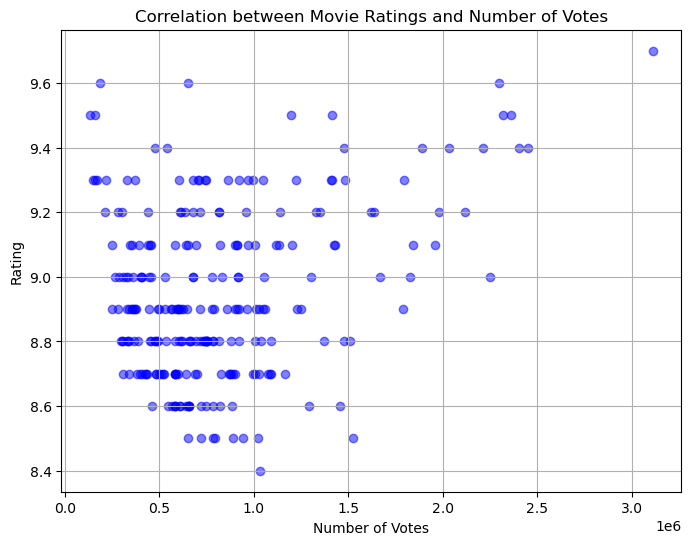

In [25]:
import matplotlib.pyplot as plt
# 确保 'rating' 和 'votes' 列为数值类型
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

# 计算评分与投票数量之间的相关性
correlation = df[['rating', 'votes']].corr().iloc[0, 1]
print(f"Correlation between movie rating and number of votes: {correlation}")

# 创建散点图
plt.figure(figsize=(8, 6))
plt.scatter(df['votes'], df['rating'], alpha=0.5, color='b')
plt.title('Correlation between Movie Ratings and Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

## I encourage to attempt each task independently before referring to the hint code. Each task can be extended further, such as adding more detailed analysis or improving visualizations.